# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Importing the Dataset and Preprocessing

In [3]:
# Importing the dataset
import pandas as pd

df2 = pd.read_csv('cleaned_review_beauty.csv')

## Adding Most Common and Lest Common Words to Stopwords List

In order to see any changes in evaluation metrics, the most and least common 70 words were added to the stopwords list and models were applied.


In [4]:
# This is the Clean Text
cln_txt = [str(txt) for text in df2['clean_text'] for txt in text.split(' ') if len(txt)>2 and txt not in 'not, nan']
word_dist = nltk.FreqDist(cln_txt)

In [5]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

stp_wrd_lst= stopwords.words('english')
for i in word_dist.most_common()[-70:]:
    stp_wrd_lst.append(i[0])
mst_c = word_dist.most_common()[:70]
for i in mst_c:
    stp_wrd_lst.append(i[0])

In [6]:
print(len(stp_wrd_lst))

319


In [7]:
# Applying the new stopwords List to the Clean Text Column

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df2['clean_text'] = df2['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) for w in text.split(' ') if w not in stp_wrd_lst]))

## Data Preparation

In [8]:
# Separating Response Variable and Feature
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [9]:
X = df2['clean_text']
y = df2['rating_class']

In [10]:
# Splitting Data into Train and Test Sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Plotting Confusion Matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def cfs_mtx(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 10)
    plt.yticks(tick_marks, classes, fontsize = 10)
    
    if normalize:
      fmt = '.2f'
    else:
      fmt = 'd'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "black" if cm[i, j] < thresh else "black", fontsize = 30)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 25)
    plt.xlabel('Predicted Label', fontsize = 25)

    return plt

In [12]:
from sklearn.metrics import confusion_matrix

def disp_cfs_mtx(y_pred, model_name, vector = 'CounterVectorizing'):

    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = cfs_mtx(cm, classes=['Bad','Good'], normalize=False, title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

# 1. CountVectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vec_train = count_vec.fit_transform(X_train)
count_vec_train = count_vec_train.toarray()
count_vec_test = count_vec.transform(X_test)
count_vec_test = count_vec_test.toarray()

In [14]:
# Creating a function for applying different algorithms
from sklearn.metrics import f1_score

def modeling(Model, Xtrain = count_vec_train, Xtest = count_vec_test, ytrain = y_train):
    
    model = Model
    model.fit(Xtrain, ytrain)
    global y_pred
    y_pred = model.predict(Xtest)
    score = f1_score(y_test, y_pred, average = 'weighted')
    print("f1 score: {}".format(score))

### 1.1 Logistic Regression (CountVectorizer)

In [15]:
from sklearn.linear_model import LogisticRegression
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))
y_pred_cv_logreg = y_pred

f1 score: 0.8815820351726522


In [16]:
# Classification report

from sklearn import metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       514
           1       0.97      0.87      0.92      6630

    accuracy                           0.86      7144
   macro avg       0.63      0.76      0.66      7144
weighted avg       0.92      0.86      0.88      7144



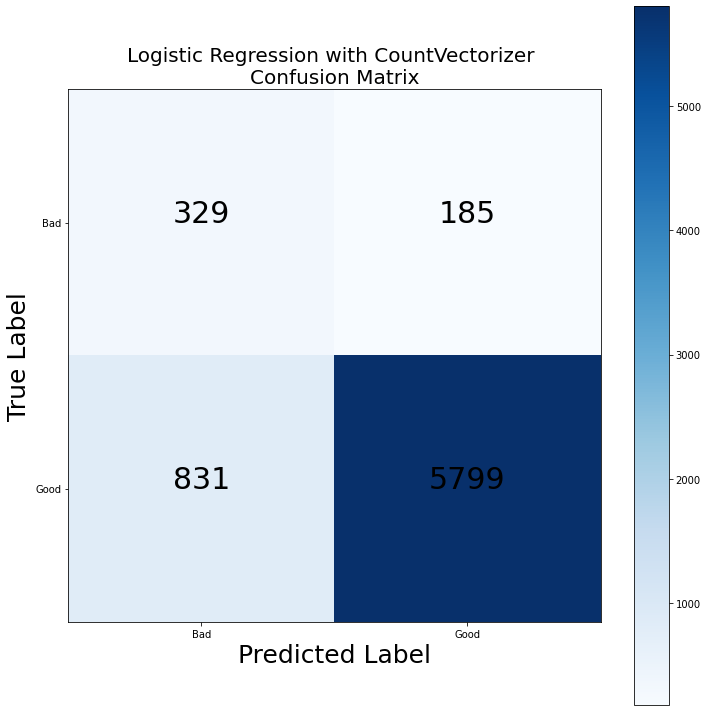

In [17]:
#Confusion Matrix
disp_cfs_mtx(y_pred_cv_logreg, "Logistic Regression", "CountVectorizer")

### 1.2 Random Forest (CountVectorizer)

In [18]:
from sklearn.ensemble import RandomForestClassifier
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))
y_pred_cv_rf = y_pred

f1 score: 0.8967707052018432


In [19]:
# Classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.69      0.02      0.04       514
           1       0.93      1.00      0.96      6630

    accuracy                           0.93      7144
   macro avg       0.81      0.51      0.50      7144
weighted avg       0.91      0.93      0.90      7144



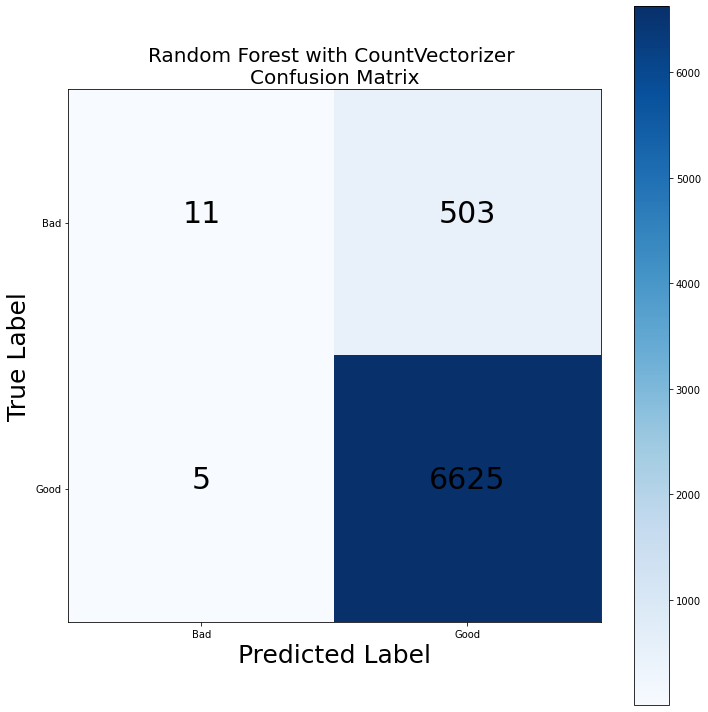

In [20]:
# Confusion Matrix
disp_cfs_mtx(y_pred_cv_rf, "Random Forest", "CountVectorizer")

### 1.3 Naive Bayes (CountVectorizer)

In [21]:
from sklearn.naive_bayes import MultinomialNB

modeling(MultinomialNB())
y_pred_cv_nb = y_pred

f1 score: 0.9085932716624708


In [22]:
# Classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.37      0.54      0.44       514
           1       0.96      0.93      0.95      6630

    accuracy                           0.90      7144
   macro avg       0.67      0.73      0.69      7144
weighted avg       0.92      0.90      0.91      7144



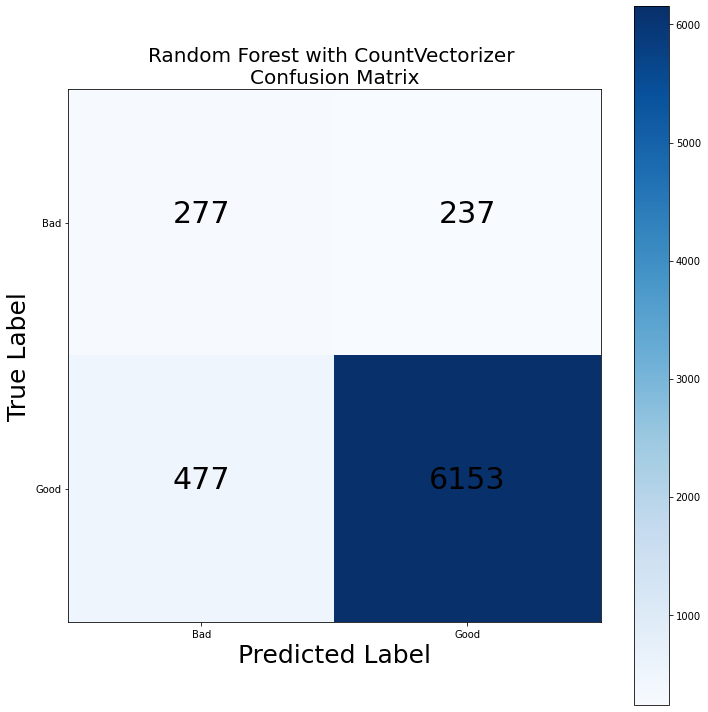

In [23]:
# Confusion Matrix
disp_cfs_mtx(y_pred_cv_nb, "Random Forest", "CountVectorizer") 

### 1.4 XGBoost (CountVectorizer)

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

modeling(XGBClassifier())
y_pred_cv_xgb = y_pred

f1 score: 0.894912737073204


In [25]:
# Classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.62      0.01      0.02       514
           1       0.93      1.00      0.96      6630

    accuracy                           0.93      7144
   macro avg       0.78      0.50      0.49      7144
weighted avg       0.91      0.93      0.89      7144



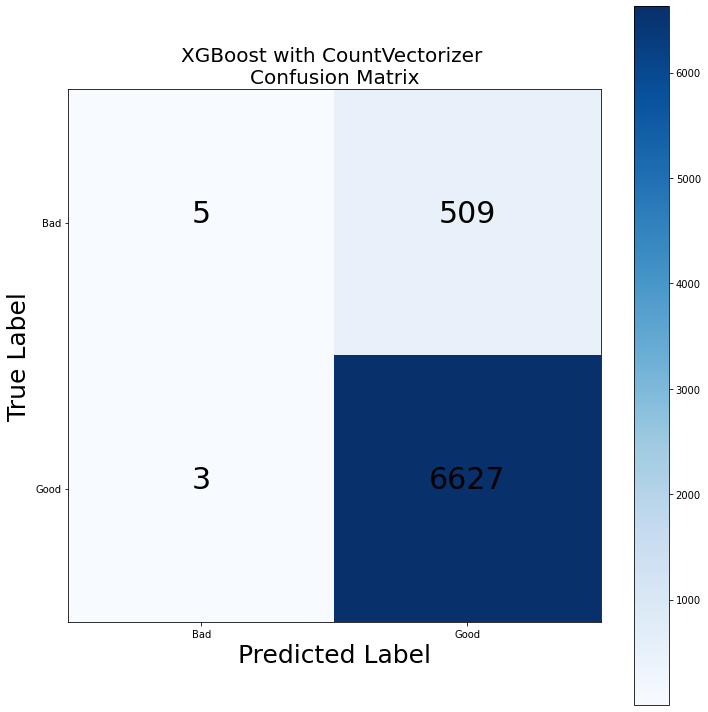

In [26]:
# Confusion Matrix
disp_cfs_mtx(y_pred_cv_xgb, "XGBoost", "CountVectorizer")

### 1.5 Catboosting (CountVectorizer)

In [27]:
from catboost import CatBoostClassifier

modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'))
y_pred_cv_catboost = y_pred

0:	learn: 0.2713916	total: 81.3ms	remaining: 2m 1s
1:	learn: 0.2570892	total: 115ms	remaining: 1m 26s
2:	learn: 0.2517925	total: 149ms	remaining: 1m 14s
3:	learn: 0.2489294	total: 182ms	remaining: 1m 8s
4:	learn: 0.2459085	total: 215ms	remaining: 1m 4s
5:	learn: 0.2440085	total: 259ms	remaining: 1m 4s
6:	learn: 0.2419532	total: 295ms	remaining: 1m 2s
7:	learn: 0.2402720	total: 328ms	remaining: 1m 1s
8:	learn: 0.2393781	total: 361ms	remaining: 59.8s
9:	learn: 0.2380338	total: 395ms	remaining: 58.8s
10:	learn: 0.2359464	total: 429ms	remaining: 58s
11:	learn: 0.2336781	total: 463ms	remaining: 57.5s
12:	learn: 0.2326493	total: 499ms	remaining: 57.1s
13:	learn: 0.2312408	total: 535ms	remaining: 56.8s
14:	learn: 0.2300169	total: 573ms	remaining: 56.7s
15:	learn: 0.2284491	total: 606ms	remaining: 56.2s
16:	learn: 0.2273550	total: 639ms	remaining: 55.7s
17:	learn: 0.2256139	total: 674ms	remaining: 55.5s
18:	learn: 0.2246281	total: 712ms	remaining: 55.5s
19:	learn: 0.2228987	total: 746ms	remain

In [28]:
# Classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.47      0.21      0.29       514
           1       0.94      0.98      0.96      6630

    accuracy                           0.93      7144
   macro avg       0.71      0.60      0.63      7144
weighted avg       0.91      0.93      0.91      7144



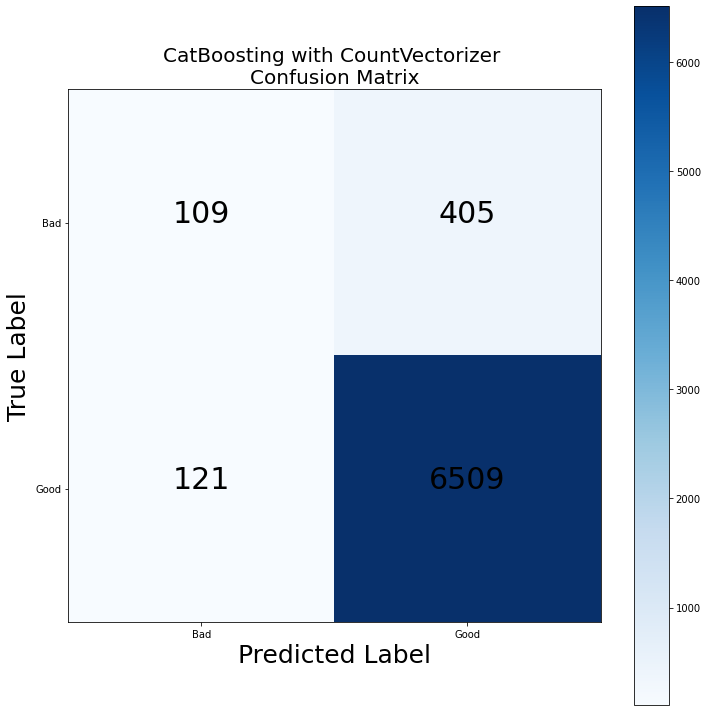

In [29]:
# Confusion Matrix
disp_cfs_mtx(y_pred_cv_catboost, "CatBoosting", "CountVectorizer")

### 1.6 Comparision of Models 

In [30]:
# Function to convert "classification report" results to a dataframe
from sklearn.metrics import precision_recall_fscore_support

def pandas_claf_rep(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)
    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary), index=metrics_sum_index)
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    class_report_df['weighted avg'] = avg

    return class_report_df.T


global compare_mat
def compare_mat(y_test, y_pred, label, vector):
    df = pandas_claf_rep(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [31]:
def compare_table(vez,y_preds, labels):
    frames_tv = [] 
    y_preds_tv = y_preds
    labels_tv = labels  
    vector_tv = vez
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = compare_mat(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [32]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Model Comparison Table**

In [33]:
compare_table(vez= 'CountVextorizer', y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [34]:
# Comparision matrix
print('\nComparision Matrix\n')
df_tv2


Comparision Matrix



precision    recall  f1-score  \
vectorizer      model         accuracy class                                    
CountVextorizer LogReg        0.857783 bad       0.283621  0.640078  0.393070   
                                       good      0.969084  0.874661  0.919455   
                                       average   0.919766  0.857783  0.881582   
                Random Forest 0.928891 bad       0.687500  0.021401  0.041509   
                                       good      0.929433  0.999246  0.963076   
                                       average   0.912026  0.928891  0.896771   
                Naive Bayes   0.900056 bad       0.367374  0.538911  0.436909   
                                       good      0.962911  0.928054  0.945161   
                                       average   0.920063  0.900056  0.908593   
                XGBoost       0.928331 bad       0.625000  0.009728  0.019157   
                                       good      0.928672  0.999548  0.962807   
                                       average   0.906823  0.928331  0.894913   
                CatBoost      0.926372 bad       0.473913  0.212062  0.293011   
                                       good      0.941423  0.981750  0.961164   
                                       average   0.907787  0.926372  0.913091   

                                                support  
vectorizer      model         accuracy class             
CountVextorizer LogReg        0.857783 bad        514.0  
                                       good      6630.0  
                                       average   7144.0  
                Random Forest 0.928891 bad        514.0  
                                       good      6630.0  
                                       average   7144.0  
                Naive Bayes   0.900056 bad        514.0  
                                       good      6630.0  
                                       average   7144.0  
                XGBoost       0.928331 bad        514.0  
                                       good      6630.0  
                                       average   7144.0  
                CatBoost      0.926372 bad        514.0  
                                       good      6630.0  
                                       average   7144.0

**Average f1 scores**

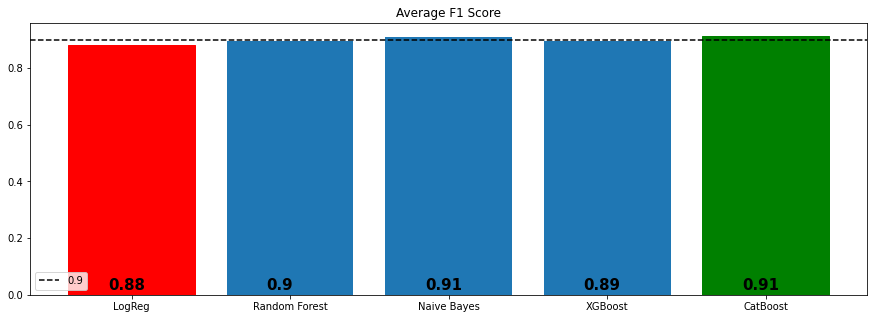

In [35]:
# f1 score for different models
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

# 2. Synthetic Minority Oversampling Technique (SMOTE)

In [36]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

smt = SMOTE(random_state=42)
df_text, df_target = smt.fit_resample(count_vec_train, y_train)
print (df_text.shape)
print (df_target.shape)

(39724, 3334)
(39724,)


In [37]:
from collections import Counter
Counter(df_target)

Counter({0: 19862, 1: 19862})

### 2.1 Logistic Regression

In [38]:
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), Xtrain = df_text, ytrain = df_target)
y_pred_sm_logreg = y_pred

f1 score: 0.8715237614831117


In [39]:
# Classification report
print(classification_report(y_test, y_pred_sm_logreg))

              precision    recall  f1-score   support

           0       0.22      0.44      0.30       514
           1       0.95      0.88      0.92      6630

    accuracy                           0.85      7144
   macro avg       0.59      0.66      0.61      7144
weighted avg       0.90      0.85      0.87      7144



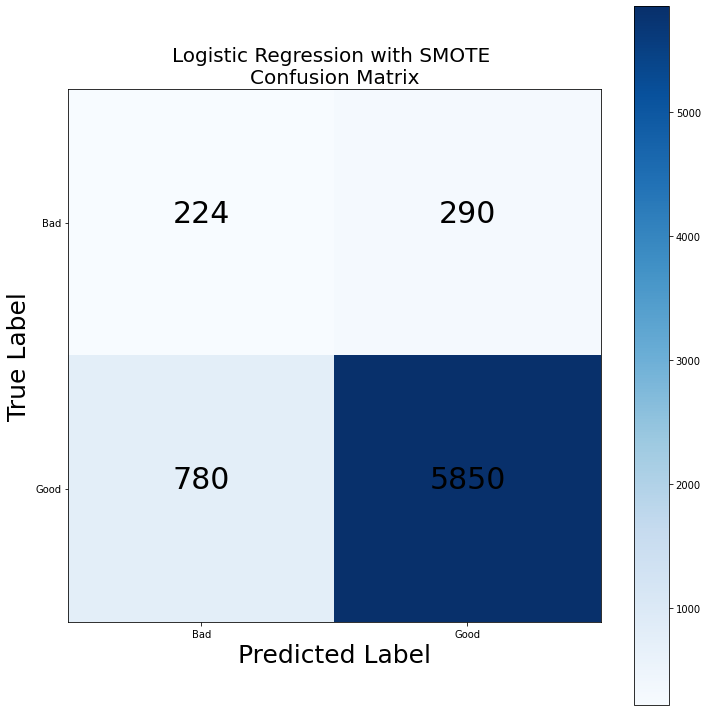

In [40]:
# Confusion Matrix 
disp_cfs_mtx(y_pred_sm_logreg, "Logistic Regression", "SMOTE")

### 2.2 Random Forest

In [41]:
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), Xtrain = df_text, ytrain = df_target)
y_pred_sm_rf = y_pred

f1 score: 0.8853263571705207


In [42]:
# Classification report
print(classification_report(y_test, y_pred_sm_rf))

              precision    recall  f1-score   support

           0       0.16      0.11      0.13       514
           1       0.93      0.95      0.94      6630

    accuracy                           0.89      7144
   macro avg       0.55      0.53      0.54      7144
weighted avg       0.88      0.89      0.89      7144



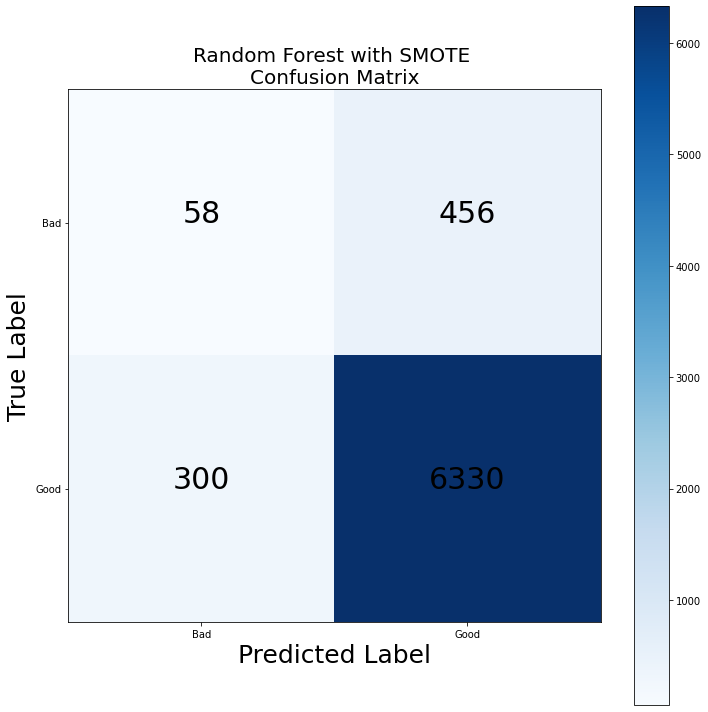

In [43]:
# Confusion Matrix
disp_cfs_mtx(y_pred_sm_rf, "Random Forest", "SMOTE")

### 2.3 Naive Bayes

In [44]:
modeling(MultinomialNB(), Xtrain = df_text, ytrain = df_target)
y_pred_sm_nb = y_pred

f1 score: 0.8871547365923174


In [45]:
# Classification report
print(classification_report(y_test, y_pred_sm_nb))

              precision    recall  f1-score   support

           0       0.27      0.47      0.35       514
           1       0.96      0.90      0.93      6630

    accuracy                           0.87      7144
   macro avg       0.62      0.69      0.64      7144
weighted avg       0.91      0.87      0.89      7144



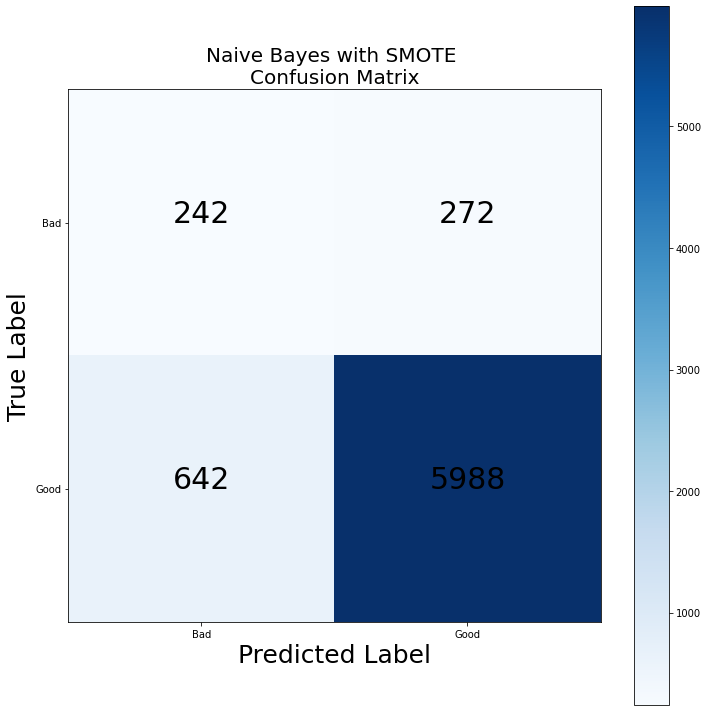

In [46]:
# Confusion Matrix
disp_cfs_mtx(y_pred_sm_nb, "Naive Bayes", "SMOTE")

### 2.4 XGBoost 

In [47]:
modeling(XGBClassifier(), Xtrain = df_text, ytrain = df_target)
y_pred_sm_xgb = y_pred

f1 score: 0.8049579601252216


In [48]:
# Classification report
print(classification_report(y_test, y_pred_sm_xgb))

              precision    recall  f1-score   support

           0       0.11      0.36      0.17       514
           1       0.94      0.78      0.85      6630

    accuracy                           0.75      7144
   macro avg       0.53      0.57      0.51      7144
weighted avg       0.88      0.75      0.80      7144



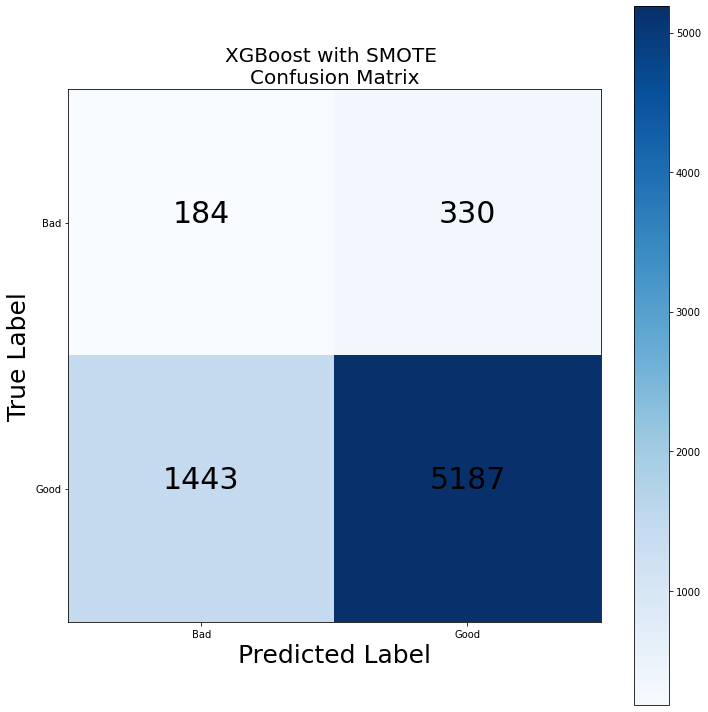

In [49]:
# Confusion Matrix
disp_cfs_mtx(y_pred_sm_xgb, "XGBoost", "SMOTE")

### 2.5 CatBoost 

In [50]:
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, loss_function='Logloss'), Xtrain = df_text, ytrain = df_target)
y_pred_sm_catboost = y_pred

0:	learn: 0.6406973	total: 80.7ms	remaining: 2m
1:	learn: 0.6086407	total: 162ms	remaining: 2m 1s
2:	learn: 0.5802617	total: 225ms	remaining: 1m 52s
3:	learn: 0.5582958	total: 290ms	remaining: 1m 48s
4:	learn: 0.5363395	total: 351ms	remaining: 1m 44s
5:	learn: 0.5181484	total: 413ms	remaining: 1m 42s
6:	learn: 0.5004474	total: 474ms	remaining: 1m 41s
7:	learn: 0.4859883	total: 536ms	remaining: 1m 40s
8:	learn: 0.4746219	total: 597ms	remaining: 1m 38s
9:	learn: 0.4635153	total: 659ms	remaining: 1m 38s
10:	learn: 0.4543898	total: 720ms	remaining: 1m 37s
11:	learn: 0.4478908	total: 786ms	remaining: 1m 37s
12:	learn: 0.4410449	total: 848ms	remaining: 1m 37s
13:	learn: 0.4345585	total: 908ms	remaining: 1m 36s
14:	learn: 0.4284050	total: 968ms	remaining: 1m 35s
15:	learn: 0.4230213	total: 1.03s	remaining: 1m 35s
16:	learn: 0.4177083	total: 1.09s	remaining: 1m 35s
17:	learn: 0.4120101	total: 1.16s	remaining: 1m 35s
18:	learn: 0.4071930	total: 1.22s	remaining: 1m 35s
19:	learn: 0.4023087	total

In [51]:
# Classification report
print(classification_report(y_test, y_pred_sm_catboost))

              precision    recall  f1-score   support

           0       0.23      0.33      0.27       514
           1       0.95      0.91      0.93      6630

    accuracy                           0.87      7144
   macro avg       0.59      0.62      0.60      7144
weighted avg       0.89      0.87      0.88      7144



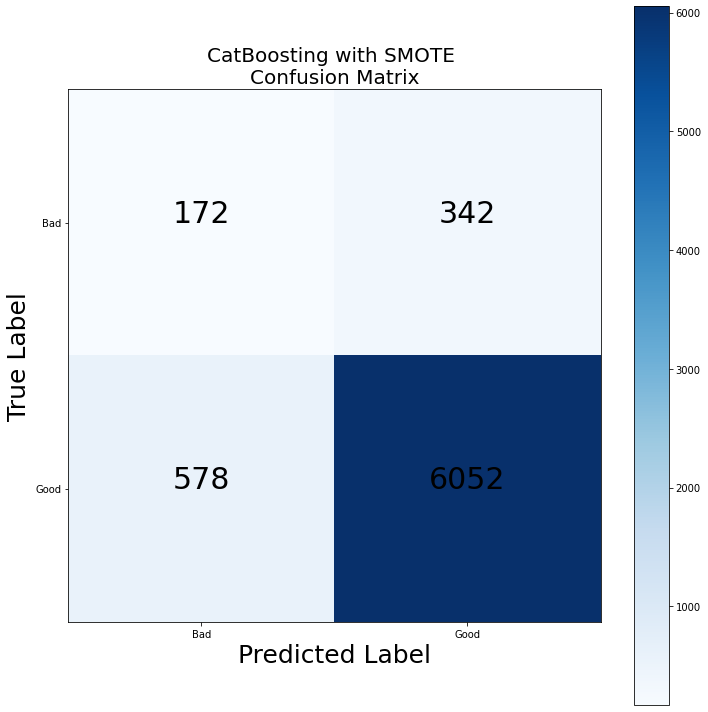

In [52]:
# Confusion Matrix
disp_cfs_mtx(y_pred_sm_catboost, "CatBoosting", "SMOTE")

### 2.6 Comparison of Models

---



In [53]:
compare_table(vez = 'CountVec (SMOTE)', y_preds = [y_pred_sm_logreg, y_pred_sm_rf, y_pred_sm_nb, y_pred_sm_xgb, y_pred_sm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] )

In [54]:
print('\nComparision Matrix\n')
df_tv2


Comparision Matrix



precision    recall  \
vectorizer       model         accuracy class                          
CountVec (SMOTE) LogReg        0.850224 bad       0.223108  0.435798   
                                        good      0.952769  0.882353   
                                        average   0.900271  0.850224   
                 Random Forest 0.894177 bad       0.162011  0.112840   
                                        good      0.932803  0.954751   
                                        average   0.877346  0.894177   
                 Naive Bayes   0.872060 bad       0.273756  0.470817   
                                        good      0.956550  0.903167   
                                        average   0.907424  0.872060   
                 XGBoost       0.751820 bad       0.113092  0.357977   
                                        good      0.940185  0.782353   
                                        average   0.880677  0.751820   
                 CatBoost      0.871221 bad       0.229333  0.334630   
                                        good      0.946512  0.912821   
                                        average   0.894912  0.871221   

                                                 f1-score  support  
vectorizer       model         accuracy class                       
CountVec (SMOTE) LogReg        0.850224 bad      0.295125    514.0  
                                        good     0.916210   6630.0  
                                        average  0.871524   7144.0  
                 Random Forest 0.894177 bad      0.133028    514.0  
                                        good     0.943649   6630.0  
                                        average  0.885326   7144.0  
                 Naive Bayes   0.872060 bad      0.346209    514.0  
                                        good     0.929092   6630.0  
                                        average  0.887155   7144.0  
                 XGBoost       0.751820 bad      0.171882    514.0  
                                        good     0.854038   6630.0  
                                        average  0.804958   7144.0  
                 CatBoost      0.871221 bad      0.272152    514.0  
                                        good     0.929361   6630.0  
                                        average  0.882076   7144.0

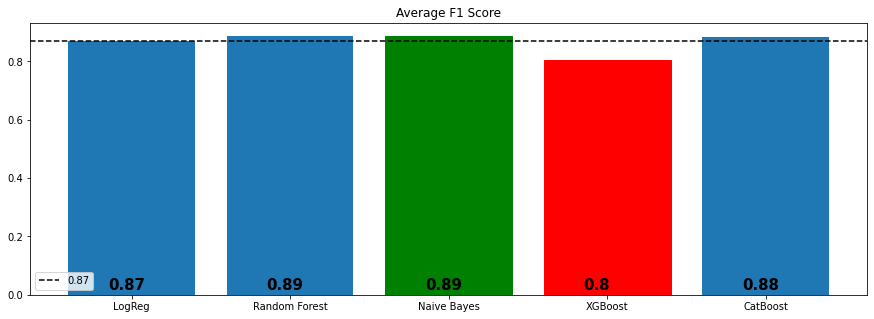

In [55]:
# f1 score
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 3. Truncated SVD + SMOTE

In [83]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(random_state=42)
svd_X_train = svd.fit_transform(count_vec_train)
svd_X_test = svd.transform(count_vec_test)

In [84]:
# Smote
smt = SMOTE(random_state=5)
df_ttext, df_ttarget = smt.fit_resample(svd_X_train, y_train)

print (df_ttext.shape)
print (df_ttarget.shape)

(39724, 2)
(39724,)


In [58]:
from collections import Counter

Counter(df_ttarget)

Counter({0: 19862, 1: 19862})

### 3.1 Logistic Regression

In [59]:
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)
y_pred_svd_logreg = y_pred

f1 score: 0.7499122698803422


In [60]:
# Classification report
print(classification_report(y_test, y_pred_svd_logreg))

              precision    recall  f1-score   support

           0       0.09      0.38      0.14       514
           1       0.93      0.69      0.80      6630

    accuracy                           0.67      7144
   macro avg       0.51      0.54      0.47      7144
weighted avg       0.87      0.67      0.75      7144



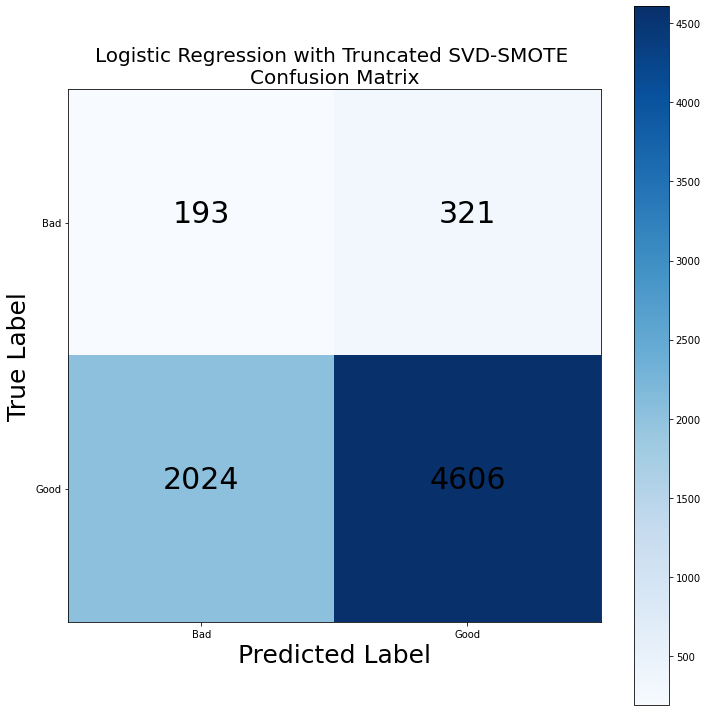

In [61]:
# Confusion Matrix
disp_cfs_mtx(y_pred_svd_logreg, "Logistic Regression", "Truncated SVD-SMOTE")

### 3.2 Random Forest

In [62]:
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)
y_pred_svd_rf = y_pred

f1 score: 0.7758606082211881


In [63]:
# Classification report
print(classification_report(y_test, y_pred_svd_rf))

              precision    recall  f1-score   support

           0       0.07      0.24      0.11       514
           1       0.93      0.75      0.83      6630

    accuracy                           0.71      7144
   macro avg       0.50      0.49      0.47      7144
weighted avg       0.86      0.71      0.78      7144



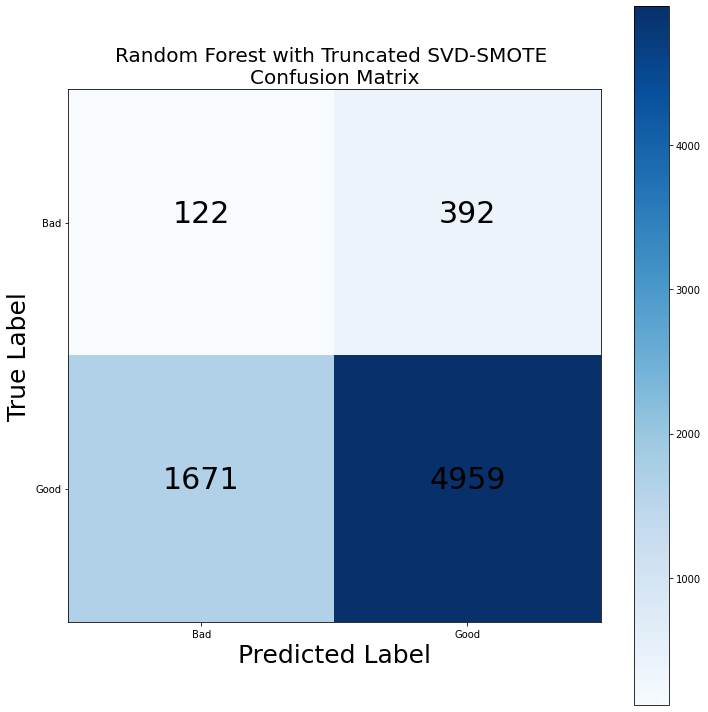

In [64]:
# Confusion Matrix
disp_cfs_mtx(y_pred_svd_rf, "Random Forest", "Truncated SVD-SMOTE")

### 3.3 XGBoost

In [65]:
modeling(XGBClassifier(), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)
y_pred_svd_xgb = y_pred

f1 score: 0.5790124466990069


In [66]:
# Classification report
print(classification_report(y_test, y_pred_svd_xgb))

              precision    recall  f1-score   support

           0       0.09      0.66      0.15       514
           1       0.94      0.45      0.61      6630

    accuracy                           0.47      7144
   macro avg       0.51      0.55      0.38      7144
weighted avg       0.88      0.47      0.58      7144



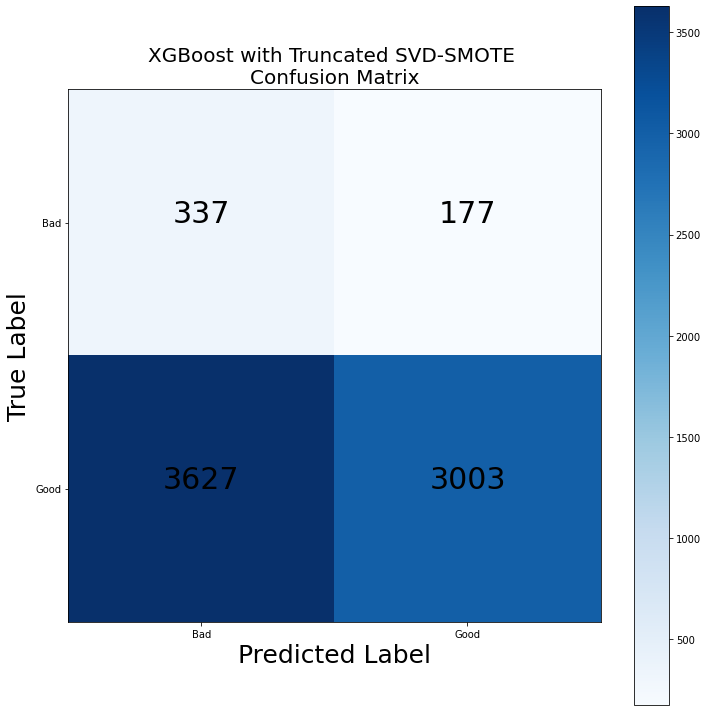

In [67]:
# Confusion Matrix
disp_cfs_mtx(y_pred_svd_xgb, "XGBoost", "Truncated SVD-SMOTE")

### 3.4 CatBoost

In [68]:
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, loss_function='Logloss'), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)
y_pred_svd_catboost = y_pred

0:	learn: 0.6863055	total: 6.46ms	remaining: 9.68s
1:	learn: 0.6843201	total: 12.3ms	remaining: 9.23s
2:	learn: 0.6828498	total: 17.3ms	remaining: 8.62s
3:	learn: 0.6813651	total: 22.7ms	remaining: 8.48s
4:	learn: 0.6796276	total: 27.7ms	remaining: 8.27s
5:	learn: 0.6782818	total: 33.3ms	remaining: 8.3s
6:	learn: 0.6773551	total: 38.3ms	remaining: 8.16s
7:	learn: 0.6757168	total: 44ms	remaining: 8.21s
8:	learn: 0.6740660	total: 48.7ms	remaining: 8.06s
9:	learn: 0.6733973	total: 53.2ms	remaining: 7.92s
10:	learn: 0.6729249	total: 58.9ms	remaining: 7.97s
11:	learn: 0.6727177	total: 63.4ms	remaining: 7.86s
12:	learn: 0.6723075	total: 68.7ms	remaining: 7.86s
13:	learn: 0.6716132	total: 73.9ms	remaining: 7.85s
14:	learn: 0.6712005	total: 79.4ms	remaining: 7.86s
15:	learn: 0.6707349	total: 84.9ms	remaining: 7.88s
16:	learn: 0.6700334	total: 96.2ms	remaining: 8.39s
17:	learn: 0.6694370	total: 106ms	remaining: 8.72s
18:	learn: 0.6686639	total: 113ms	remaining: 8.83s
19:	learn: 0.6680646	total:

In [69]:
# Classification report
print(classification_report(y_test, y_pred_svd_catboost))

              precision    recall  f1-score   support

           0       0.08      0.45      0.14       514
           1       0.93      0.61      0.73      6630

    accuracy                           0.59      7144
   macro avg       0.51      0.53      0.44      7144
weighted avg       0.87      0.59      0.69      7144



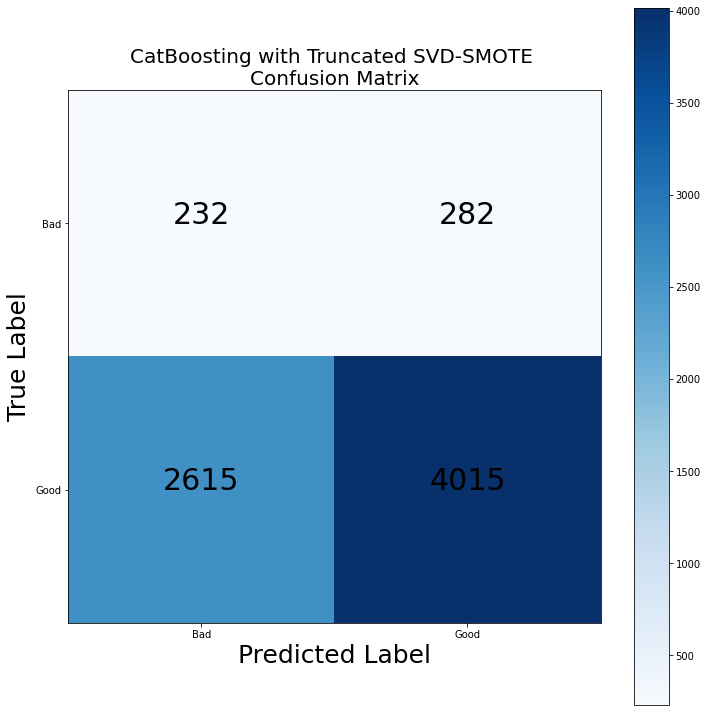

In [70]:
# Confusion Matrix
disp_cfs_mtx(y_pred_svd_catboost, "CatBoosting", "Truncated SVD-SMOTE")

### 3.5 Comparison of Models

In [71]:
compare_table(vez = 'TruncatedSVD',y_preds = [y_pred_svd_logreg, y_pred_svd_rf, y_pred_svd_xgb, y_pred_svd_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [72]:
print('\nComparision Matrix\n')
df_tv2


Comparision Matrix



precision    recall  f1-score  \
vectorizer   model         accuracy class                                    
TruncatedSVD LogReg        0.671753 bad       0.087055  0.375486  0.141340   
                                    good      0.934849  0.694721  0.797093   
                                    average   0.873851  0.671753  0.749912   
             Random Forest 0.711226 bad       0.068042  0.237354  0.105765   
                                    good      0.926743  0.747964  0.827811   
                                    average   0.864960  0.711226  0.775861   
             XGBoost       0.467525 bad       0.085015  0.655642  0.150514   
                                    good      0.944340  0.452941  0.612232   
                                    average   0.882513  0.467525  0.579012   
             CatBoost      0.594485 bad       0.081489  0.451362  0.138054   
                                    good      0.934373  0.605581  0.734877   
                                    average   0.873009  0.594485  0.691936   

                                             support  
vectorizer   model         accuracy class             
TruncatedSVD LogReg        0.671753 bad        514.0  
                                    good      6630.0  
                                    average   7144.0  
             Random Forest 0.711226 bad        514.0  
                                    good      6630.0  
                                    average   7144.0  
             XGBoost       0.467525 bad        514.0  
                                    good      6630.0  
                                    average   7144.0  
             CatBoost      0.594485 bad        514.0  
                                    good      6630.0  
                                    average   7144.0

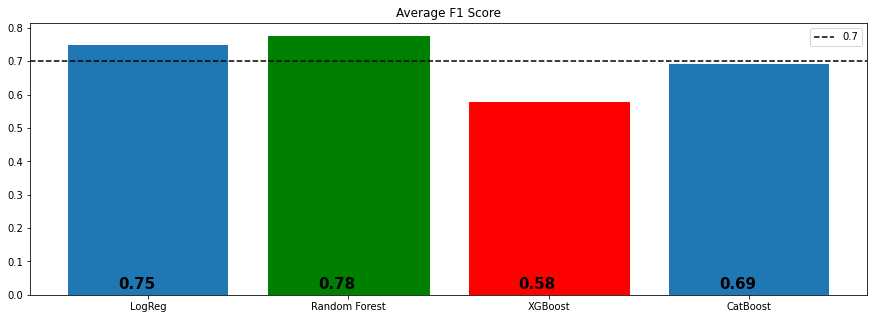

In [73]:
# f1 score
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")